#Time-Series Model Throwdown
ts_model_throwdown.ipynb

Compare models A and B using multiple datasets processed by the loaders in load data time-series repository.

* Builds numpy arrays using load_dataset functions and default arguments
* Builds/Trains/Evaluates two models for the selected dataset
* Displays several model evaluation figures and metrics side-by-side

See also load_dataset_demo.ipynb which is a bit more interactive.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* Leotta still requires high-RAM runtime.  Several loaders output too much info.
* Maybe compile the model in build?
* This version copied from internal repository 2/19/2023 - I need to make a number of changes to integrate with the latest loaders and remove the need to mount google drive.



In [1]:
my_dir = '.'
verbose = True

In [2]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import urllib.request # to get files from web w/o !wget
import gc

# temp - needed for SHL split
from sklearn.model_selection import train_test_split

# Get load_data_utils from IMICS public repository

In [3]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')

In [4]:
import load_data_utils as utils # ldu just seemed confusing!
print('My env_info: \n' + utils.get_env_info()) # using + vs , gets rid of space

My env_info: 
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
GPU: name, driver_version, memory.total [MiB]
Tesla T4, 525.85.12, 15360 MiB



#Get numpy arrays using load_dataset

In [5]:
# Copy selected .py file into colab and import load_dataset function
# k_size is the size of the kernel used in the model, one-half of a second
# works well, actual value is based on sample freq e.g. 32Hz -> k_size = 16.
# EPOCHS are max run, training also has early stopping callback
def get_dataset(dataset):
    if (dataset == 'MobiAct HAR'):
        if (os.path.exists('MobiAct_Dataset_v1.0.zip')):
            print ("Local MobiAct zip found, skipping download")
        else:
            !gdown "1kt9wtIt7N7SIFQAbav7zcZ_PqTa5HegA&confirm=t" # MobiAct alternate file source
        # original share is https://drive.google.com/uc?id=0B5VcW5yHhWhibWxGRTZDd0dGY2s'
        # please see https://bmi.hmu.gr/the-mobifall-and-mobiact-datasets-2/ if not working
        get_py_file(fname = 'mobiact_adl_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/MobiAct/mobiact_adl_load_dataset.py')
        from mobiact_adl_load_dataset import mobiact_adl_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = mobiact_adl_load_dataset(incl_val_group = True)
        k_size = 50
        EPOCHS = 50
        t_names = ['JOG','JUM','STD','STN','STU','WAL']
    elif (dataset == 'UniMiB SHAR'):
        get_py_file(fname = 'unimib_adl_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UniMiB_SHAR/unimib_shar_adl_load_dataset.py')
        from unimib_adl_load_dataset import unimib_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = unimib_load_dataset(incl_val_group = True)
        t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']
        k_size = 50
        EPOCHS = 60
    elif (dataset == 'UCI HAR'):
        get_py_file(fname = 'uci_har_load_dataset.py', 
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UCI_HAR/uci_har_load_dataset.py')
        from uci_har_load_dataset import uci_har_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = uci_har_load_dataset(incl_val_group = True, incl_xyz_accel= True)
        t_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
        k_size = 50
        EPOCHS = 120
    elif (dataset == 'TWristAR'):
        # Note TWristAR is more updated than the previous datasets so the accesses
        # and defaults are a bit different, e.g. t_names is pulled from the .py
        get_py_file(fname = 'twristar_load_dataset.py', 
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')
        import twristar_load_dataset as twristar_load_dataset # diff to get label map
        x_train, y_train, x_valid, y_valid, x_test, y_test \
                                = twristar_load_dataset.twristar_load_dataset(
                                    incl_val_group = True,
                                    one_hot_encode = True)
        t_names = list(twristar_load_dataset.label_map_twristar.get('label').keys())
        t_names.remove('Undefined')
        k_size = 16
        EPOCHS = 100
    elif (dataset == 'Leotta_2021'):
        get_py_file(fname = 'leotta_2021_load_dataset.py', 
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/ADL/Leotta_2021/leotta_2021_load_dataset.py')
        #full_filename = my_path+os.path.join('/ADL/Leotta_2021/'+'leotta_2021_load_dataset.py')
        #shutil.copy(full_filename,'leotta_2021_load_dataset.py')
        import leotta_2021_load_dataset as leotta_2021_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test, log_info = leotta_2021_load_dataset.leotta_2021_load_dataset(incl_val_group = True)
        # Note:  OTHER referenced in readme.txt was deleted during the processing,
        # and the one-hot encoding shifted everything by one, hence RELAX = 0 now
        t_names = ['RELAX','KEYBOARD_WRITING','LAPTOP','HANDWRITING',
                    'HANDWASHING','FACEWASHING','TEETHBRUSH','SWEEPING','VACUUMING',
                    'EATING','DUSTING','RUBBING','DOWNSTAIRS','WALKING',
                    'WALKING_FAST','UPSTAIRS_FAST','UPSTAIRS']
        k_size = 100
        EPOCHS = 50
    elif (dataset == 'SHL'):
        # SHL takes about 30 minutes to process due to size, using saved arrays for now
        !gdown "1ApHVQ-P2reO6ctNVxeHHxCHeoNlp6c9P&confirm=t" # SHL 20Hz
        utils.unzip_into_dir('SHL_20hz_for_gentry.zip','SHL')
        input_dir = './SHL'
        x_train = np.load(input_dir + '/'+'x_train.npy')
        x_train = np.delete(x_train, [0,1,2], 2) # delete component accel
        x_test = np.load(input_dir + '/'+'x_test.npy')
        x_test = np.delete(x_test, [0,1,2], 2) # delete component accel
        y_train = np.load(input_dir + '/'+'y_train.npy')
        y_test = np.load(input_dir + '/'+'y_test.npy')
        # also don't have validate working in SHL so just using stratify
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

        t_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
        k_size = 15
        EPOCHS = 100
    elif (dataset == 'Gesture Phase Segmentation'):
        get_py_file(fname = 'gesture_phase_segmentation_load_dataset.py', 
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/Gesturing_Signing/gesture_phase_segmentation_load_dataset.py')
        from gesture_phase_segmentation_load_dataset import gesture_phase_segmentation_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                                = gesture_phase_segmentation_load_dataset(
                                    incl_val_group = True,
                                    return_info_dict = True)
        print("Note: Due to the size of the Gesture Phase Segmentation and for",
            "\ncompatibility, the test arrays are copies of the valid arrays")
        x_test = x_valid.copy()
        y_test = y_valid.copy()
        t_names = ["Rest", "Preparation", "Stroke","Hold", "Retraction"]
        k_size = 9
        EPOCHS = 100
    else:
        print('ERROR: dataset unknown')
    print(utils.tabulate_numpy_arrays({'x_train':x_train,'y_train':y_train,
                                    'x_valid':x_valid,'y_valid':y_valid,
                                    'x_test':x_test,'y_test':y_test}))  
    return x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names

In [ ]:
# This is the original throwdown loader - cell above copied from ts_demo.
# Copy selected .py file into colab and import load_dataset function
# k_size is the size of the kernel used in the model, one-half of a second
# works well, actual value is based on sample freq e.g. 32Hz -> k_size = 16.
# EPOCHS are max run, training also has early stopping callback
# def get_dataset(dataset):
#     if (dataset == 'MobiAct_ADL'):
#         full_filename = my_path+os.path.join('/HAR/MobiAct/'+'mobiact_adl_load_dataset.py')
#         shutil.copy(full_filename,'mobiact_adl_load_dataset.py')
#         # MobiAct uses local copy due to difficulty automatically downloading from source.
#         zip_ffname = my_dir+os.path.join('/drive/MyDrive/Datasets/MobiAct_Dataset_v1.0.zip')
#         shutil.copy(zip_ffname,'MobiAct_Dataset_v1.0.zip')
#         from mobiact_adl_load_dataset import mobiact_adl_load_dataset
#         x_train, y_train, x_valid, y_valid, x_test, y_test = mobiact_adl_load_dataset(incl_val_group = True)
#         k_size = 50
#         EPOCHS = 50
#         t_names = ['JOG','JUM','STD','STN','STU','WAL']
        
#     elif (dataset == 'UniMiB_SHAR'):
#         full_filename = my_path+ os.path.join('/HAR/UniMiB_SHAR/'+'unimib_shar_adl_load_dataset.py')
#         shutil.copy(full_filename,'unimib_shar_adl_load_dataset.py')
#         from unimib_shar_adl_load_dataset import unimib_load_dataset
#         x_train, y_train, x_valid, y_valid, x_test, y_test = unimib_load_dataset(incl_val_group = True)
#         t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']
#         k_size = 50
#         EPOCHS = 60
#     elif (dataset == 'UCI_HAR'):
#         full_filename = my_path+os.path.join('/HAR/UCI_HAR/'+'uci_har_load_dataset.py')
#         shutil.copy(full_filename,'uci_har_load_dataset.py')
#         from uci_har_load_dataset import uci_har_load_dataset
#         x_train, y_train, x_valid, y_valid, x_test, y_test = uci_har_load_dataset(incl_val_group = True)
#         t_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
#         k_size = 50
#         EPOCHS = 120
#     elif (dataset == 'TWristAR'):
#         full_filename = my_path+os.path.join('/HAR/e4_wristband_Nov2019/'+'e4_load_dataset.py')
#         shutil.copy(full_filename,'e4_load_dataset.py')
#         from e4_load_dataset import e4_load_dataset
#         x_train, y_train, x_valid, y_valid, x_test, y_test = e4_load_dataset(incl_val_group = True, incl_xyz_accel= True)
#         t_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
#         k_size = 16
#         EPOCHS = 100
#     elif (dataset == 'Leotta_2021'):
#         full_filename = my_path+os.path.join('/ADL/Leotta_2021/'+'leotta_2021_load_dataset.py')
#         shutil.copy(full_filename,'leotta_2021_load_dataset.py')
#         from leotta_2021_load_dataset import leotta_2021_load_dataset
#         x_train, y_train, x_valid, y_valid, x_test, y_test, log_info = leotta_2021_load_dataset(incl_val_group = True)
#         # Note:  OTHER referenced in readme.txt was deleted during the processing,
#         # and the one-hot encoding shifted everything by one, hence RELAX = 0 now
#         t_names = ['RELAX','KEYBOARD_WRITING','LAPTOP','HANDWRITING',
#                     'HANDWASHING','FACEWASHING','TEETHBRUSH','SWEEPING','VACUUMING',
#                     'EATING','DUSTING','RUBBING','DOWNSTAIRS','WALKING',
#                     'WALKING_FAST','UPSTAIRS_FAST','UPSTAIRS']
#         k_size = 33
#         EPOCHS = 50
#     elif (dataset == 'SHL'):
#         # the existing .py has been tested but not with saved IRs.
#         # using a version _temp that may only work with save IRs for now.
#         full_filename = my_path+os.path.join('/HAR/SHL/'+'shl_load_dataset_temp.py')
#         shutil.copy(full_filename,'shl_load_dataset.py')
#         from shl_load_dataset import shl_load_dataset
#         print("Without saved IR3 (X, y ,sub) this will take an hour+ to run")
#         x_train, y_train, x_valid, y_valid, x_test, y_test \
#                              = shl_load_dataset(verbose = False,
#                                                 use_saved_xysub = True,
#                                                 incl_val_group = True,
#                                                 return_info_dict = False)
#         t_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
#         k_size = 17
#         EPOCHS = 50
#     elif (dataset == 'PSG-Audio'):
#         # the mini psg-audio loader lacks full functionality
#         full_filename = my_path+os.path.join('/Sleep/'+'psg_audio_mini_loader.py')
#         shutil.copy(full_filename,'psg_audio_mini_loader.py')
#         from psg_audio_mini_loader import psga_mini_load_dataset
#         print("using PSG-Audio mini-loader")
#         x_train, y_train, x_valid, y_valid, x_test, y_test = psga_mini_load_dataset(incl_val_group=True)
#         t_names = ['Normal','Apnea', 'Hypopnea']
#         k_size = 35
#         EPOCHS = 50 
#     else:
#         print('ERROR: dataset unknown')
#     return x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names

# This test to confirm all datasets can be loaded before running a long evaluation pass.

In [6]:
ds_list = ["MobiAct HAR", 
           "UniMiB SHAR",
           "UCI HAR",
           "TWristAR",
           #"Leotta_2021",
           "SHL",
           "Gesture Phase Segmentation"
           #"PSG-Audio"
           ]
pre_validate = True
if pre_validate:
    for i in ds_list:
        dataset = i
        print("**** Processing ", dataset, " ****")
        x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names = get_dataset(dataset)
        print(dataset)
        print(utils.tabulate_numpy_arrays({"x_train":x_train, "y_train":y_train,
                                        "x_valid":x_valid, "y_valid":y_valid,
                                        "x_test" :x_test,  "y_test":y_test}))
        print("k_size =",k_size,"(typically a half-second worth of samples or less)")
        print("Class names =",t_names)



**** Processing  MobiAct HAR  ****
Downloading...
From: https://drive.google.com/uc?id=1kt9wtIt7N7SIFQAbav7zcZ_PqTa5HegA&confirm=t
To: /content/MobiAct_Dataset_v1.0.zip
100% 392M/392M [00:04<00:00, 91.7MB/s]
Unzipping MobiAct Dataset
Generating filenames  JOG_acc_*.txt  from  MobiAct_Dataset/JOG/  directory
Generating filenames  JUM_acc_*.txt  from  MobiAct_Dataset/JUM/  directory
Generating filenames  STD_acc_*.txt  from  MobiAct_Dataset/STD/  directory
Generating filenames  STN_acc_*.txt  from  MobiAct_Dataset/STN/  directory
Generating filenames  STU_acc_*.txt  from  MobiAct_Dataset/STU/  directory
Generating filenames  WAL_acc_*.txt  from  MobiAct_Dataset/WAL/  directory
array    shape           data type
-------  --------------  -----------
x_train  (4190, 500, 1)  float64
y_train  (4190, 6)       float64
x_valid  (1397, 500, 1)  float64
y_valid  (1397, 6)       float64
x_test   (1395, 500, 1)  float64
y_test   (1395, 6)       float64
MobiAct HAR
array    shape           data type

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


90/10 split of the training group.  It is not subject independent.
array    shape          data type
-------  -------------  -----------
x_train  (1869, 96, 1)  float32
y_train  (1869, 6)      uint8
x_valid  (208, 96, 1)   float32
y_valid  (208, 6)       uint8
x_test   (1091, 96, 1)  float32
y_test   (1091, 6)      uint8
TWristAR
array    shape          data type
-------  -------------  -----------
x_train  (1869, 96, 1)  float32
y_train  (1869, 6)      uint8
x_valid  (208, 96, 1)   float32
y_valid  (208, 6)       uint8
x_test   (1091, 96, 1)  float32
y_test   (1091, 6)      uint8
k_size = 16 (typically a half-second worth of samples or less)
Class names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
**** Processing  SHL  ****
Downloading...
From: https://drive.google.com/uc?id=1ApHVQ-P2reO6ctNVxeHHxCHeoNlp6c9P&confirm=t
To: /content/SHL_20hz_for_gentry.zip
100% 58.6M/58.6M [00:00<00:00, 131MB/s]
array    shape            data type
-------  ---------------  -

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#Model A: LSTM model
Credit Brownlee, model example 
[here](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/)

In [7]:
# Model credit Jason Brownlee
# https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# even though this is an interactive notebook, I've put train and test into
# functions hoping this will make it easier to swap models in the future
modelA_desc = "LSTM RNN, Credit: Brownlee"
def build_modelA(x_train, y_train, k_size):
    #k_size is not used for the lstm model
  #verbose, epochs, batch_size = 0, 15, 64 # original values, not set in train
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
  model = keras.Sequential(
    [
	    layers.LSTM(100, input_shape=(n_timesteps,n_features)),
        layers.Dropout(0.5),
	    layers.Dense(100, activation='relu'),
	    layers.Dense(n_outputs, activation='softmax')
        ])
  return model
  	#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
if (False): #set to True while developing new model
    x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names = get_dataset('UCI_HAR')
    modelA = build_modelA(x_train, y_train, k_size)
    keras.utils.plot_model(modelA, 'modelA.png',show_shapes=True)
    plt.imshow(plt.imread('modelA.png'))
    

#Model B: 1D CNN model with Global Average Pooling Layer
topology and good article
[here](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)

In [8]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# even though this is an interactive notebook, I've put train and test into
# functions hoping this will make it easier to swap models in the future
modelB_desc = "Two 1D-CNN and GlobalAvgPool"
def build_modelB(x_train, y_train, k_size):
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

  model = keras.Sequential(
    [
      layers.Conv1D(filters=100, kernel_size=k_size, activation='relu',input_shape=(n_timesteps,n_features)),
      layers.Conv1D(filters=100, kernel_size=k_size, activation='relu'),
      layers.GlobalAveragePooling1D(),
      layers.Dense(n_outputs, activation='softmax')
    ])
  return model
if (False): #set to True while developing new model
    modelB = build_modelB(x_train, y_train, k_size)
    keras.utils.plot_model(modelB, 'modelB.png',show_shapes=True)

#Train the model, evaluate using validation set

In [9]:
def train_model(model, x_train, y_train, x_valid, y_valid,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    NUM_EPOCHS = 100): # Max number run unless earlystopping callback fires
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=7)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        x_train,y_train,
        batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        validation_data=(x_valid,y_valid),
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model

# Run the model - predict using the test data

In [10]:
def run_model(model,x_test):
    predictions = model.predict(x_test, verbose = 0, batch_size = 64)
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    return y_pred

**** Processing  MobiAct HAR  ****
Local MobiAct zip found, skipping download
Local mobiact_adl_load_dataset.py found, skipping download
Using existing archive
Generating filenames  JOG_acc_*.txt  from  MobiAct_Dataset/JOG/  directory
Generating filenames  JUM_acc_*.txt  from  MobiAct_Dataset/JUM/  directory
Generating filenames  STD_acc_*.txt  from  MobiAct_Dataset/STD/  directory
Generating filenames  STN_acc_*.txt  from  MobiAct_Dataset/STN/  directory
Generating filenames  STU_acc_*.txt  from  MobiAct_Dataset/STU/  directory
Generating filenames  WAL_acc_*.txt  from  MobiAct_Dataset/WAL/  directory
array    shape           data type
-------  --------------  -----------
x_train  (4190, 500, 1)  float64
y_train  (4190, 6)       float64
x_valid  (1397, 500, 1)  float64
y_valid  (1397, 6)       float64
x_test   (1395, 500, 1)  float64
y_test   (1395, 6)       float64
Epoch 1/100
131/131 [==============================] - 12s 28ms/step - loss: 0.9715 - accuracy: 0.6807 - val_loss: 0.412

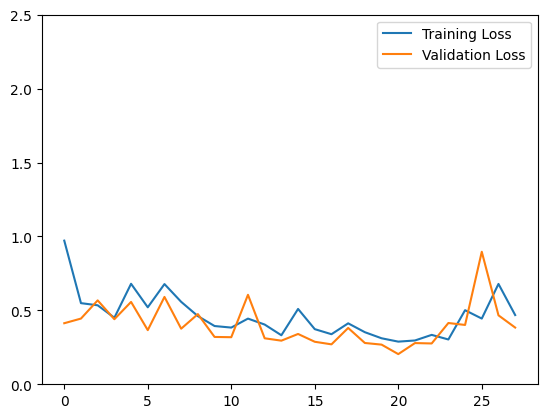

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         JOG       0.91      0.83      0.87       147
         JUM       0.94      0.92      0.93       145
         STD       1.00      1.00      1.00       425
         STN       0.00      0.00      0.00        60
         STU       0.00      0.00      0.00        60
         WAL       0.80      1.00      0.89       558

    accuracy                           0.89      1395
   macro avg       0.61      0.62      0.61      1395
weighted avg       0.82      0.89      0.85      1395



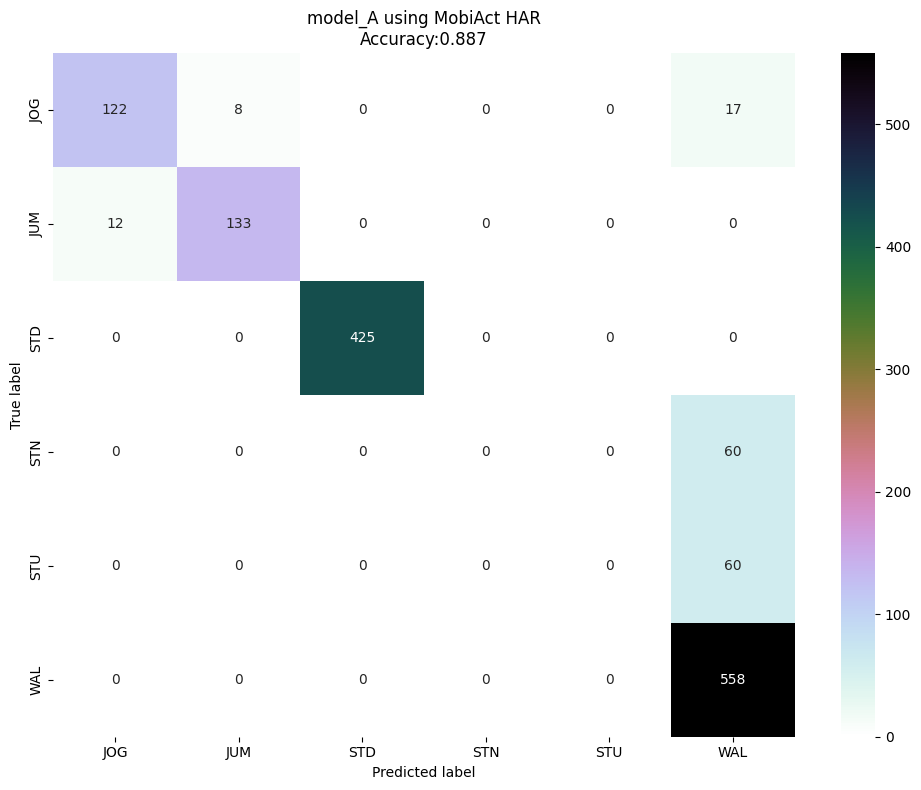

Epoch 1/100
131/131 [==============================] - 8s 14ms/step - loss: 0.7128 - accuracy: 0.7988 - val_loss: 0.1012 - val_accuracy: 0.9757
Epoch 2/100
131/131 [==============================] - 1s 9ms/step - loss: 0.1221 - accuracy: 0.9647 - val_loss: 0.0634 - val_accuracy: 0.9785
Epoch 3/100
131/131 [==============================] - 1s 11ms/step - loss: 0.0975 - accuracy: 0.9711 - val_loss: 0.0484 - val_accuracy: 0.9878
Epoch 4/100
131/131 [==============================] - 1s 10ms/step - loss: 0.0528 - accuracy: 0.9821 - val_loss: 0.0662 - val_accuracy: 0.9771
Epoch 5/100
131/131 [==============================] - 1s 9ms/step - loss: 0.0448 - accuracy: 0.9862 - val_loss: 0.0357 - val_accuracy: 0.9893
Epoch 6/100
131/131 [==============================] - 1s 9ms/step - loss: 0.0413 - accuracy: 0.9876 - val_loss: 0.0358 - val_accuracy: 0.9907
Epoch 7/100
131/131 [==============================] - 1s 9ms/step - loss: 0.0239 - accuracy: 0.9931 - val_loss: 0.0356 - val_accuracy: 0.9

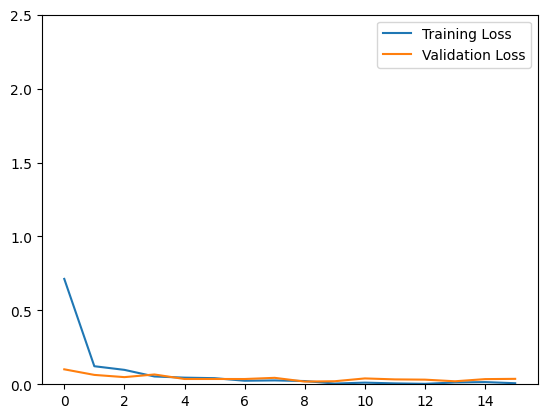

              precision    recall  f1-score   support

         JOG       0.97      0.90      0.94       147
         JUM       0.97      1.00      0.99       145
         STD       1.00      1.00      1.00       425
         STN       0.84      0.90      0.87        60
         STU       0.76      0.90      0.82        60
         WAL       0.99      0.97      0.98       558

    accuracy                           0.97      1395
   macro avg       0.92      0.95      0.93      1395
weighted avg       0.97      0.97      0.97      1395



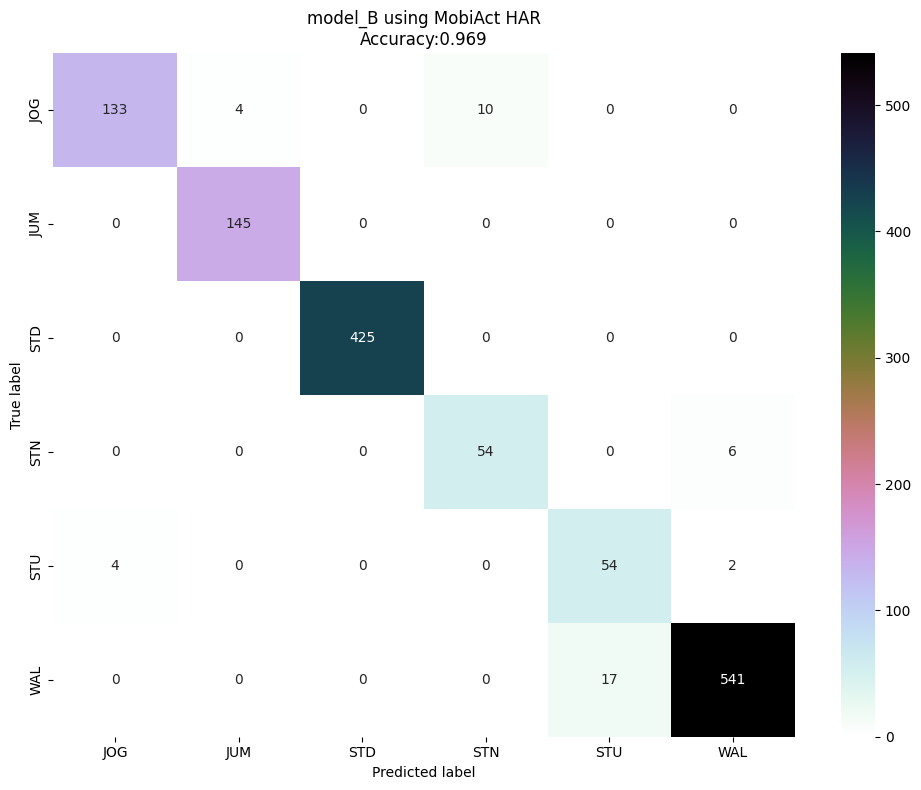

**** Processing  UniMiB SHAR  ****
Local unimib_adl_load_dataset.py found, skipping download
Raw data     shape        object type              data type
-----------  -----------  -----------------------  -----------
adl_data:    (7579, 453)  <class 'numpy.ndarray'>  float64
adl_labels:  (7579, 3)    <class 'numpy.ndarray'>  uint8
adl_names:   (9, 1)       <class 'numpy.ndarray'>  object
Reshaped data    shape           object type              data type
---------------  --------------  -----------------------  -----------
adl_data:        (7579, 151, 1)  <class 'numpy.ndarray'>  float64
adl_labels:      (7579, 3)       <class 'numpy.ndarray'>  uint8
adl_names:       (9, 1)          <class 'numpy.ndarray'>  object
x/y_train shape  (4601, 151, 1) (4601,)
x/y_validation shape  (1454, 151, 1) (1454,)
x/y_test shape   (1524, 151, 1) (1524,)
After one-hot encoding
x/y_train shape  (4601, 151, 1) (4601, 9)
x/y_validation shape  (1454, 151, 1) (1454, 9)
x/y_test shape   (1524, 151, 1) (1524, 

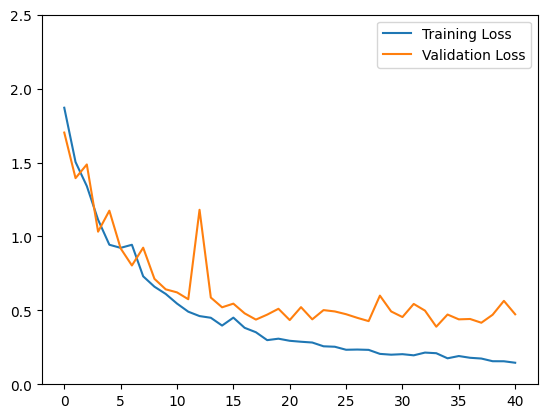

              precision    recall  f1-score   support

StandingUpFS       0.55      0.53      0.54        34
StandingUpFL       0.56      0.51      0.53        47
     Walking       0.95      0.94      0.95       344
     Running       1.00      0.99      0.99       413
    GoingUpS       0.81      0.88      0.84       184
     Jumping       0.97      0.98      0.98       146
  GoingDownS       0.95      0.93      0.94       256
 LyingDownFS       0.59      0.51      0.55        68
 SittingDown       0.59      0.72      0.65        32

    accuracy                           0.90      1524
   macro avg       0.77      0.78      0.77      1524
weighted avg       0.90      0.90      0.90      1524



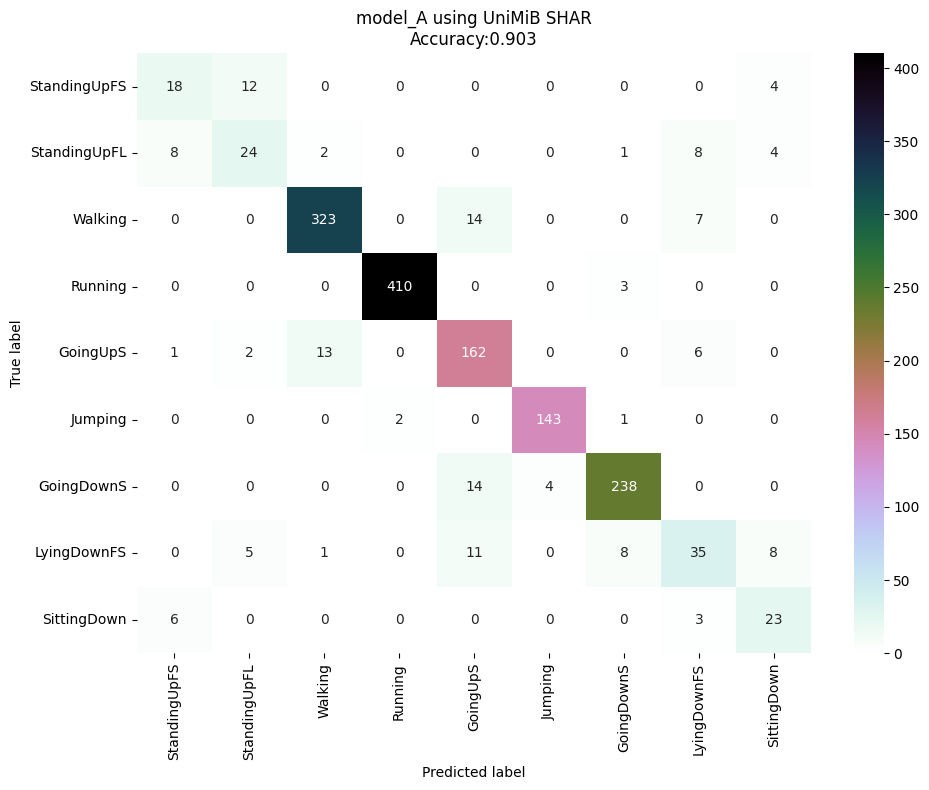

Epoch 1/100
144/144 [==============================] - 4s 11ms/step - loss: 1.1637 - accuracy: 0.6170 - val_loss: 0.7926 - val_accuracy: 0.7517
Epoch 2/100
144/144 [==============================] - 1s 5ms/step - loss: 0.7214 - accuracy: 0.7698 - val_loss: 0.7186 - val_accuracy: 0.7552
Epoch 3/100
144/144 [==============================] - 1s 5ms/step - loss: 0.5268 - accuracy: 0.8209 - val_loss: 0.5080 - val_accuracy: 0.8343
Epoch 4/100
144/144 [==============================] - 1s 7ms/step - loss: 0.4648 - accuracy: 0.8433 - val_loss: 0.4283 - val_accuracy: 0.8466
Epoch 5/100
144/144 [==============================] - 1s 7ms/step - loss: 0.3824 - accuracy: 0.8618 - val_loss: 0.4297 - val_accuracy: 0.8666
Epoch 6/100
144/144 [==============================] - 1s 7ms/step - loss: 0.3317 - accuracy: 0.8779 - val_loss: 0.3811 - val_accuracy: 0.8707
Epoch 7/100
144/144 [==============================] - 1s 6ms/step - loss: 0.3080 - accuracy: 0.8874 - val_loss: 0.3285 - val_accuracy: 0.902

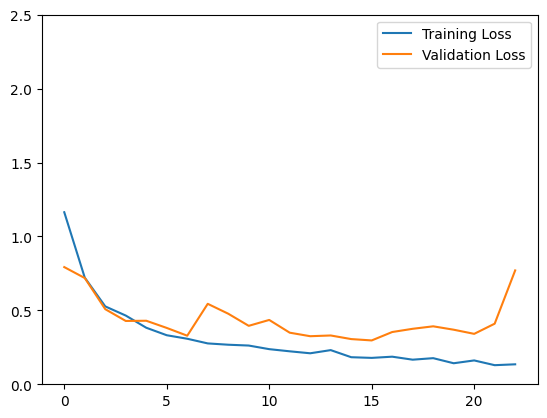

              precision    recall  f1-score   support

StandingUpFS       0.89      0.74      0.81        34
StandingUpFL       0.78      0.53      0.63        47
     Walking       0.89      1.00      0.94       344
     Running       1.00      0.99      1.00       413
    GoingUpS       0.86      0.90      0.88       184
     Jumping       1.00      0.66      0.80       146
  GoingDownS       0.89      0.98      0.93       256
 LyingDownFS       0.54      0.76      0.63        68
 SittingDown       1.00      0.03      0.06        32

    accuracy                           0.90      1524
   macro avg       0.87      0.73      0.74      1524
weighted avg       0.91      0.90      0.89      1524



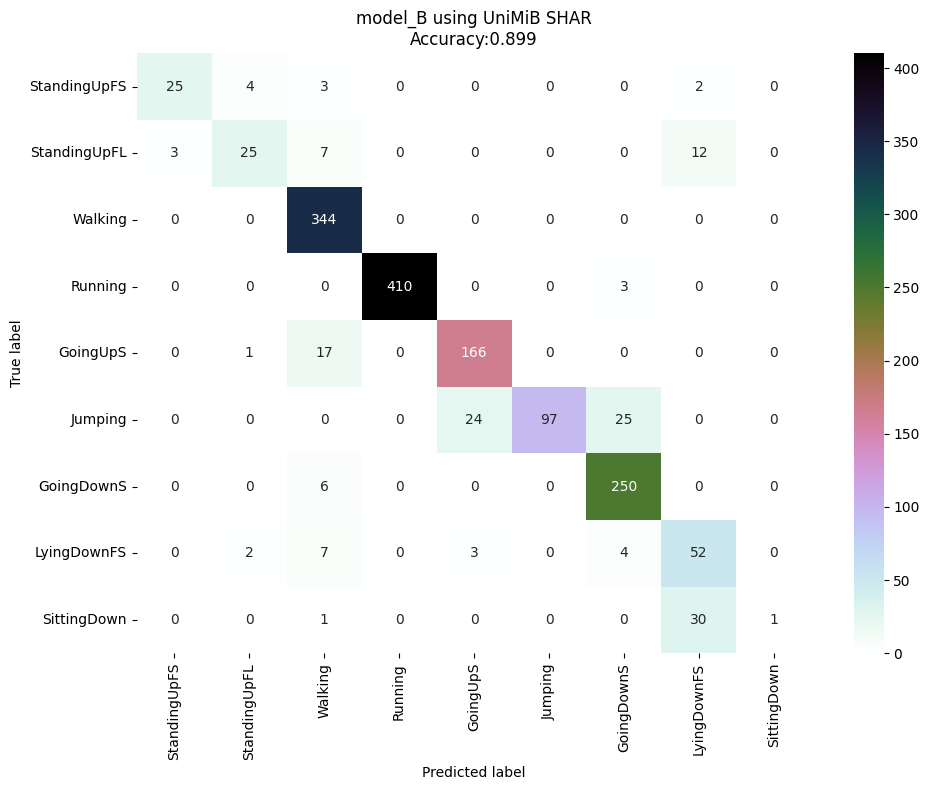

**** Processing  UCI HAR  ****
Local uci_har_load_dataset.py found, skipping download

The validation group is generated using sklearn stratify on train
It is not subject independent - confirm accuracy with test set
array    shape           data type
-------  --------------  -----------
x_train  (5514, 128, 4)  float64
y_train  (5514, 6)       float32
x_valid  (1838, 128, 4)  float64
y_valid  (1838, 6)       float32
x_test   (2947, 128, 4)  float64
y_test   (2947, 6)       float32
Epoch 1/100
173/173 [==============================] - 5s 13ms/step - loss: 1.2932 - accuracy: 0.3252 - val_loss: 1.1630 - val_accuracy: 0.3498
Epoch 2/100
173/173 [==============================] - 2s 10ms/step - loss: 1.1303 - accuracy: 0.3640 - val_loss: 1.0998 - val_accuracy: 0.3879
Epoch 3/100
173/173 [==============================] - 2s 9ms/step - loss: 1.1914 - accuracy: 0.3808 - val_loss: 1.0380 - val_accuracy: 0.4396
Epoch 4/100
173/173 [==============================] - 2s 12ms/step - loss: 1.1254 

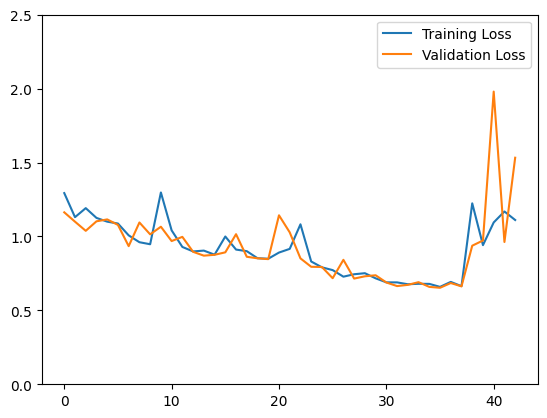

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

           WALKING       0.35      0.31      0.33       496
  WALKING_UPSTAIRS       0.57      0.16      0.25       471
WALKING_DOWNSTAIRS       0.94      0.45      0.60       420
           SITTING       0.23      1.00      0.37       491
          STANDING       0.00      0.00      0.00       532
            LAYING       0.00      0.00      0.00       537

          accuracy                           0.31      2947
         macro avg       0.35      0.32      0.26      2947
      weighted avg       0.32      0.31      0.24      2947



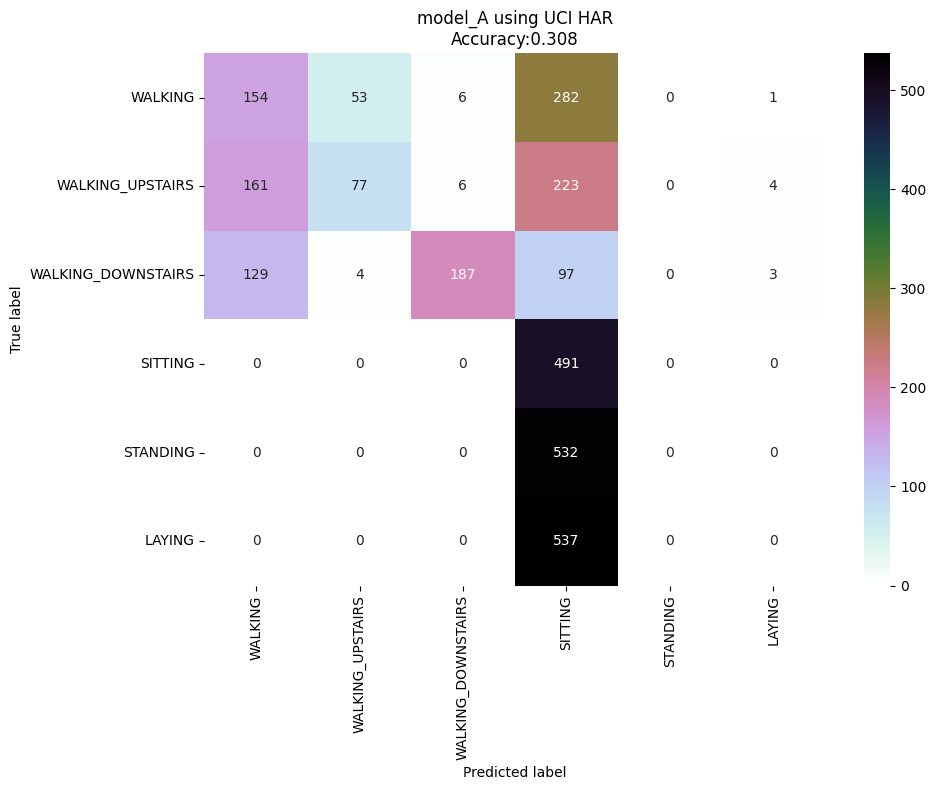

Epoch 1/100
173/173 [==============================] - 3s 8ms/step - loss: 0.9001 - accuracy: 0.5557 - val_loss: 0.6554 - val_accuracy: 0.6251
Epoch 2/100
173/173 [==============================] - 1s 5ms/step - loss: 0.6121 - accuracy: 0.6687 - val_loss: 0.5805 - val_accuracy: 0.7133
Epoch 3/100
173/173 [==============================] - 1s 5ms/step - loss: 0.5407 - accuracy: 0.7394 - val_loss: 0.5111 - val_accuracy: 0.7764
Epoch 4/100
173/173 [==============================] - 1s 5ms/step - loss: 0.4699 - accuracy: 0.7833 - val_loss: 0.4416 - val_accuracy: 0.8014
Epoch 5/100
173/173 [==============================] - 1s 5ms/step - loss: 0.4171 - accuracy: 0.8143 - val_loss: 0.4049 - val_accuracy: 0.8139
Epoch 6/100
173/173 [==============================] - 1s 6ms/step - loss: 0.3844 - accuracy: 0.8288 - val_loss: 0.3959 - val_accuracy: 0.8259
Epoch 7/100
173/173 [==============================] - 1s 6ms/step - loss: 0.3654 - accuracy: 0.8404 - val_loss: 0.3987 - val_accuracy: 0.8259

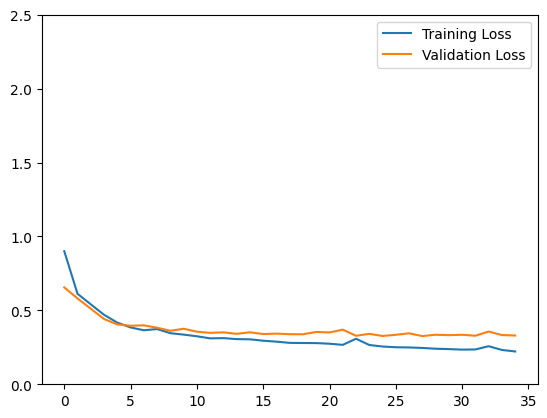

                    precision    recall  f1-score   support

           WALKING       0.98      0.94      0.96       496
  WALKING_UPSTAIRS       0.99      0.93      0.96       471
WALKING_DOWNSTAIRS       0.90      1.00      0.95       420
           SITTING       0.63      0.49      0.56       491
          STANDING       0.65      0.85      0.74       532
            LAYING       0.88      0.81      0.84       537

          accuracy                           0.83      2947
         macro avg       0.84      0.84      0.83      2947
      weighted avg       0.84      0.83      0.83      2947



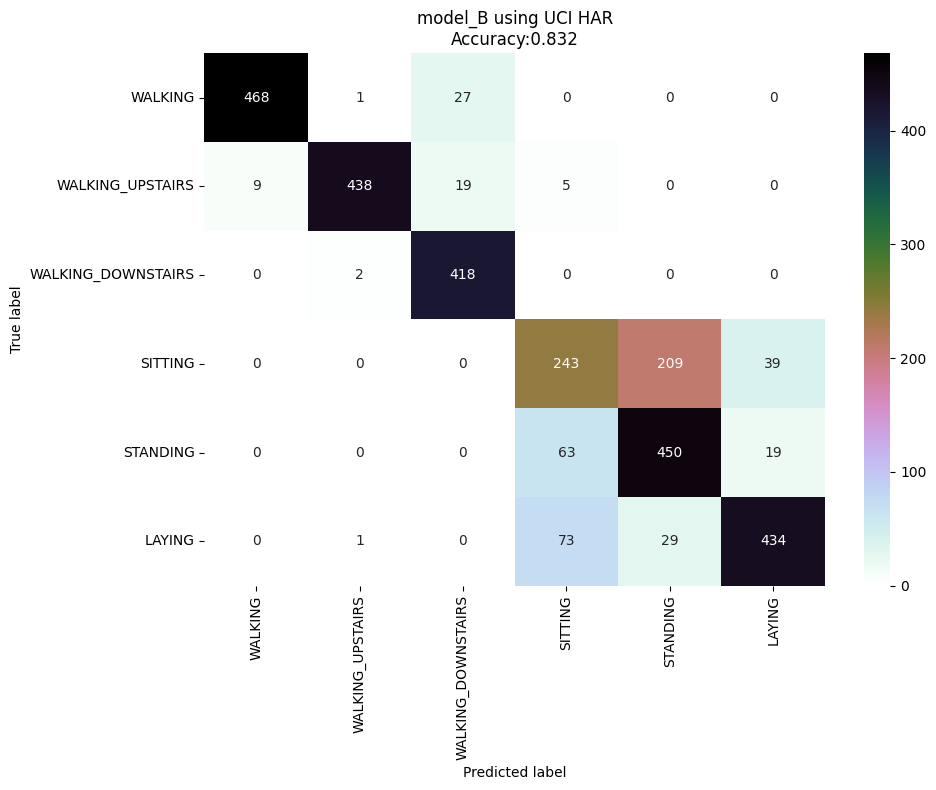

**** Processing  TWristAR  ****
Local twristar_load_dataset.py found, skipping download


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


90/10 split of the training group.  It is not subject independent.
array    shape           data type
-------  --------------  -----------
x_train  (12294, 30, 1)  float32
y_train  (12294, 6)      uint8
x_valid  (1366, 30, 1)   float32
y_valid  (1366, 6)       uint8
x_test   (7163, 30, 1)   float32
y_test   (7163, 6)       uint8
Epoch 1/100
385/385 [==============================] - 5s 7ms/step - loss: 1.0873 - accuracy: 0.4654 - val_loss: 0.8134 - val_accuracy: 0.5637
Epoch 2/100
385/385 [==============================] - 3s 7ms/step - loss: 0.7865 - accuracy: 0.5887 - val_loss: 0.7036 - val_accuracy: 0.6047
Epoch 3/100
385/385 [==============================] - 3s 7ms/step - loss: 0.7043 - accuracy: 0.6325 - val_loss: 0.6730 - val_accuracy: 0.6530
Epoch 4/100
385/385 [==============================] - 2s 6ms/step - loss: 0.6616 - accuracy: 0.6737 - val_loss: 0.6292 - val_accuracy: 0.6772
Epoch 5/100
385/385 [==============================] - 2s 6ms/step - loss: 0.6180 - accuracy: 0.7

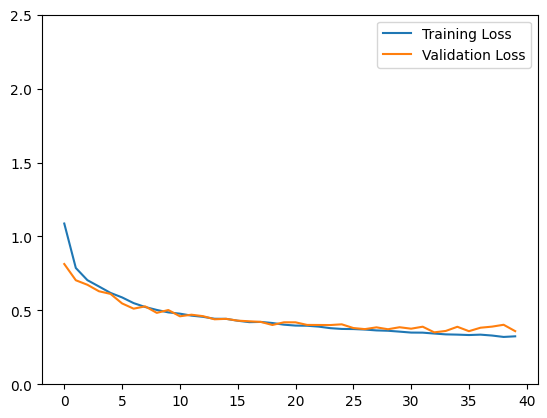

              precision    recall  f1-score   support

  Downstairs       0.79      0.67      0.72      1157
     Jogging       0.92      0.34      0.49      1128
     Sitting       0.75      0.67      0.71      1115
    Standing       0.73      0.73      0.73      1212
    Upstairs       0.51      0.86      0.64      1315
     Walking       0.62      0.68      0.65      1236

    accuracy                           0.66      7163
   macro avg       0.72      0.66      0.66      7163
weighted avg       0.71      0.66      0.66      7163



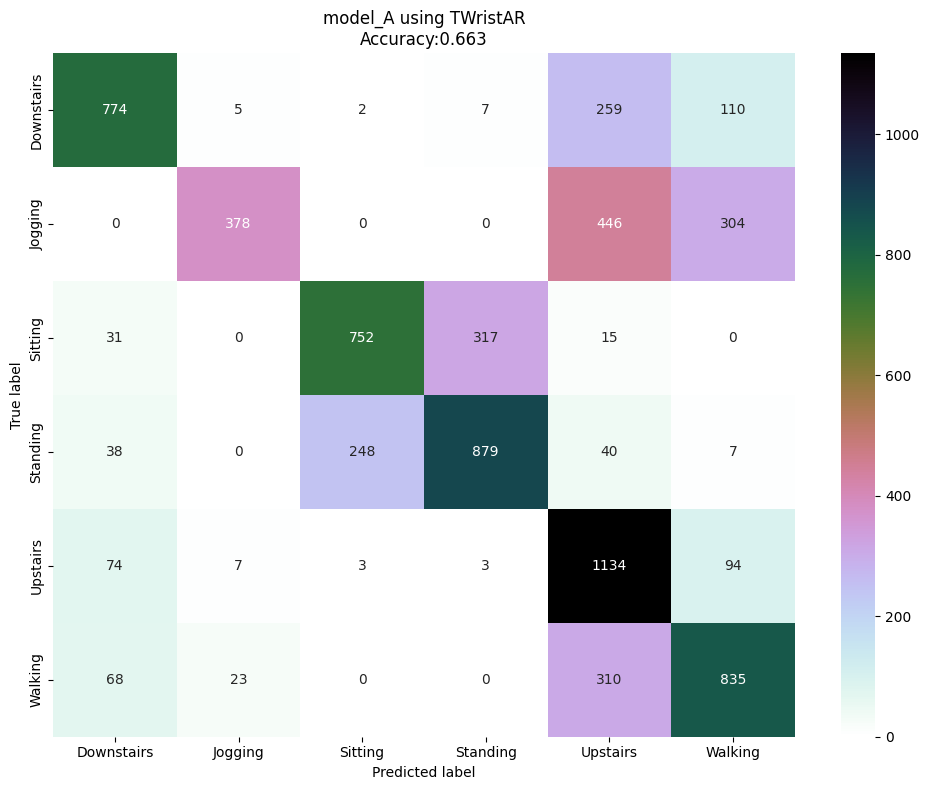

ValueError: ignored

In [11]:
#TODO Leotta returns log_info - need to add that to the others
# List is built above with option to validate
#ds_list = ["MobiAct_ADL", "UniMiB_SHAR","UCI_HAR", "TWristAR","Leotta_2021", "SHL","PSG-Audio"]
#ds_list = ["Leotta_2021", "SHL","PSG-Audio"]
log_out = "Running: " + str(', '.join(ds_list))
modelA_acc = []
modelB_acc = []
model = None # just to keep from running erroneous pass
for i in ds_list:
    dataset = i
    print("**** Processing ", dataset, " ****")
    x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names = get_dataset(dataset)

    model_names = ['model_A','model_B']
    model = None # just to keep from running erroneous pass
    #acknowledgement to @MikeHordecki https://stackoverflow.com/questions/522563/accessing-the-index-in-for-loops
    for idx, curr_mname in enumerate(model_names):   
        if (idx == 0):
            model = build_modelA(x_train, y_train, k_size)
        elif (idx == 1):
            model = build_modelB(x_train, y_train, k_size)
        else:
            print ("Something went wrong!")
            model = None # just to keep from running erroneous pass
        plot_name = curr_mname +'_'+ dataset + '.png'
        keras.utils.plot_model(model, plot_name, show_shapes=True)
        history, model = train_model(model, x_train, y_train, x_valid, y_valid)
        #show final training loss
        print(curr_mname, "evaluate using", dataset)
        print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.ylim([0,2.5]) #set limit - 1.2 has been a good value experimentally
        plt.legend()
        plt.show()
        y_pred = run_model(model, x_test)
        y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
        acc = accuracy_score(y_test_act, y_pred)
        if (idx == 0):
            modelA_acc.append(acc)
        if (idx == 1):
            modelB_acc.append(acc)
        print(classification_report(y_test_act, y_pred, target_names=t_names))
        cm = confusion_matrix(y_test_act, y_pred)
        cm_df = pd.DataFrame(cm,
                            index = t_names, 
                            columns = t_names)
        cm_height = 10 # was 1.2*len(t_names)/2
        cm_width = 8 # was len(t_names)/2)
        fig = plt.figure(figsize=(cm_height,cm_width)) # num classes => size
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
        plt.title(curr_mname +' using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout() # keeps labels from being cutoff when saving as pdf
        cmplot_name = curr_mname  +'_'+ dataset + '_cm.png'
        plt.savefig(cmplot_name, dpi = 300) 
        plt.show()
        gc.collect()
modelA_results = 'Model A: '+(np.array2string(np.asarray(modelA_acc), precision = 3))
modelA_results += ' mean:'+(np.array2string(np.mean(modelA_acc), precision = 3))
modelB_results = 'Model B: '+(np.array2string(np.asarray(modelB_acc), precision = 3))
modelB_results += ' mean:'+(np.array2string(np.mean(modelB_acc), precision = 3))
log_out += '\n' + modelA_results + '\n' + modelB_results
print(log_out)

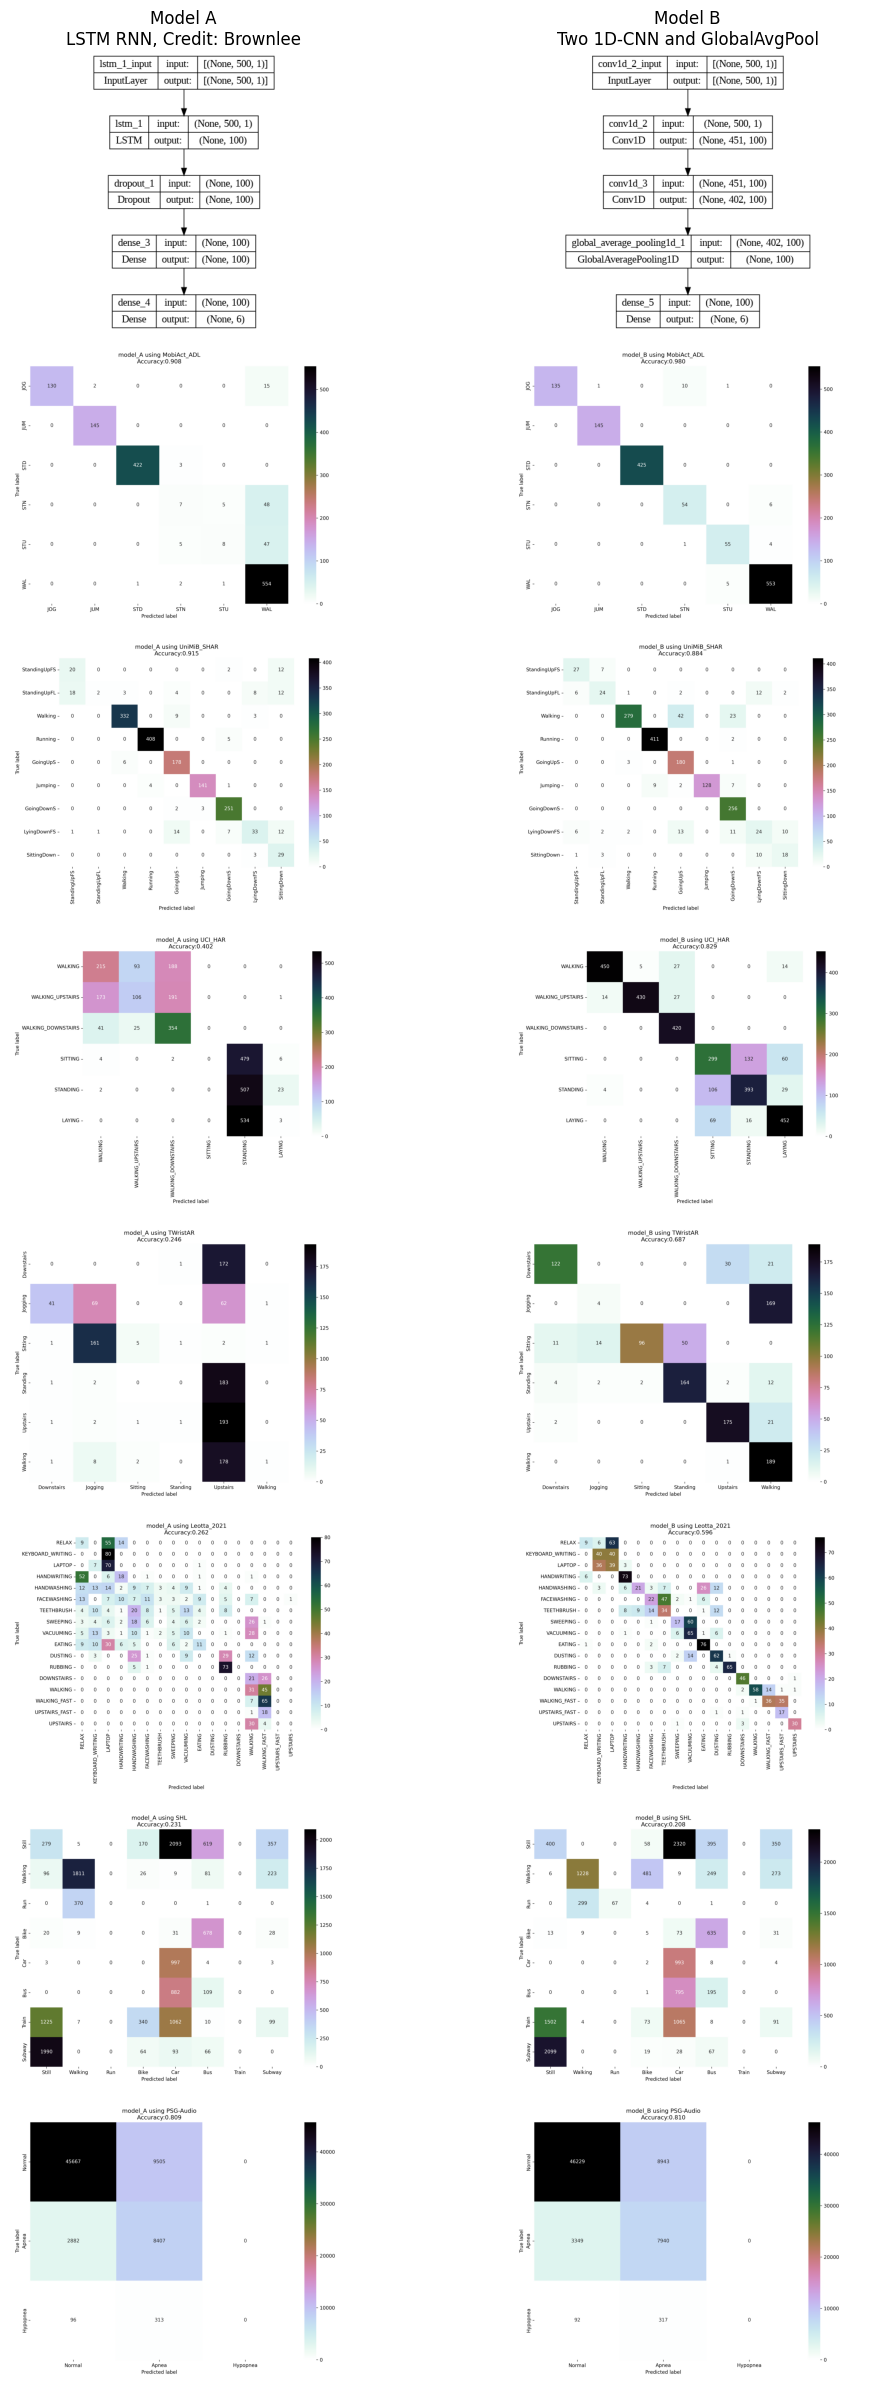

In [ ]:
#plot side by side
#https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html?highlight=subplots
#spacing needs to be adjusted
# see https://matplotlib.org/stable/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py
# see https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
rows = 8
cols = 2
fig, axs = plt.subplots(nrows=rows, ncols=cols)#, figsize = (40,10))
fig.set_size_inches(12,24)
for i in range(rows):
    for j in range(cols):
        axs[i, j].set_axis_off()
#axs[0, 0].set_title(modelA_results+'\n'+modelA_desc)
#axs[0, 1].set_title(modelB_results+'\n'+modelB_desc)
axs[0, 0].set_title('Model A\n'+ modelA_desc)
axs[0, 1].set_title('Model B\n'+ modelB_desc)
axs[0, 0].imshow(plt.imread('model_A_MobiAct_ADL.png'))
axs[0, 1].imshow(plt.imread('model_B_MobiAct_ADL.png'))
axs[1, 0].imshow(plt.imread('model_A_MobiAct_ADL_cm.png'))
axs[1, 1].imshow(plt.imread('model_B_MobiAct_ADL_cm.png'))
axs[2, 0].imshow(plt.imread('model_A_UniMiB_SHAR_cm.png'))
axs[2, 1].imshow(plt.imread('model_B_UniMiB_SHAR_cm.png'))
axs[3, 0].imshow(plt.imread('model_A_UCI_HAR_cm.png'))
axs[3, 1].imshow(plt.imread('model_B_UCI_HAR_cm.png'))
axs[4, 0].imshow(plt.imread('model_A_TWristAR_cm.png'))
axs[4, 1].imshow(plt.imread('model_B_TWristAR_cm.png'))
axs[5, 0].imshow(plt.imread('model_A_Leotta_2021_cm.png'))
axs[5, 1].imshow(plt.imread('model_B_Leotta_2021_cm.png'))
axs[6, 0].imshow(plt.imread('model_A_SHL_cm.png'))
axs[6, 1].imshow(plt.imread('model_B_SHL_cm.png'))
axs[7, 0].imshow(plt.imread('model_A_PSG-Audio_cm.png'))
axs[7, 1].imshow(plt.imread('model_B_PSG-Audio_cm.png'))

plt.tight_layout()
plt.savefig('throwdown.png', dpi = 300) # don't forget to download!


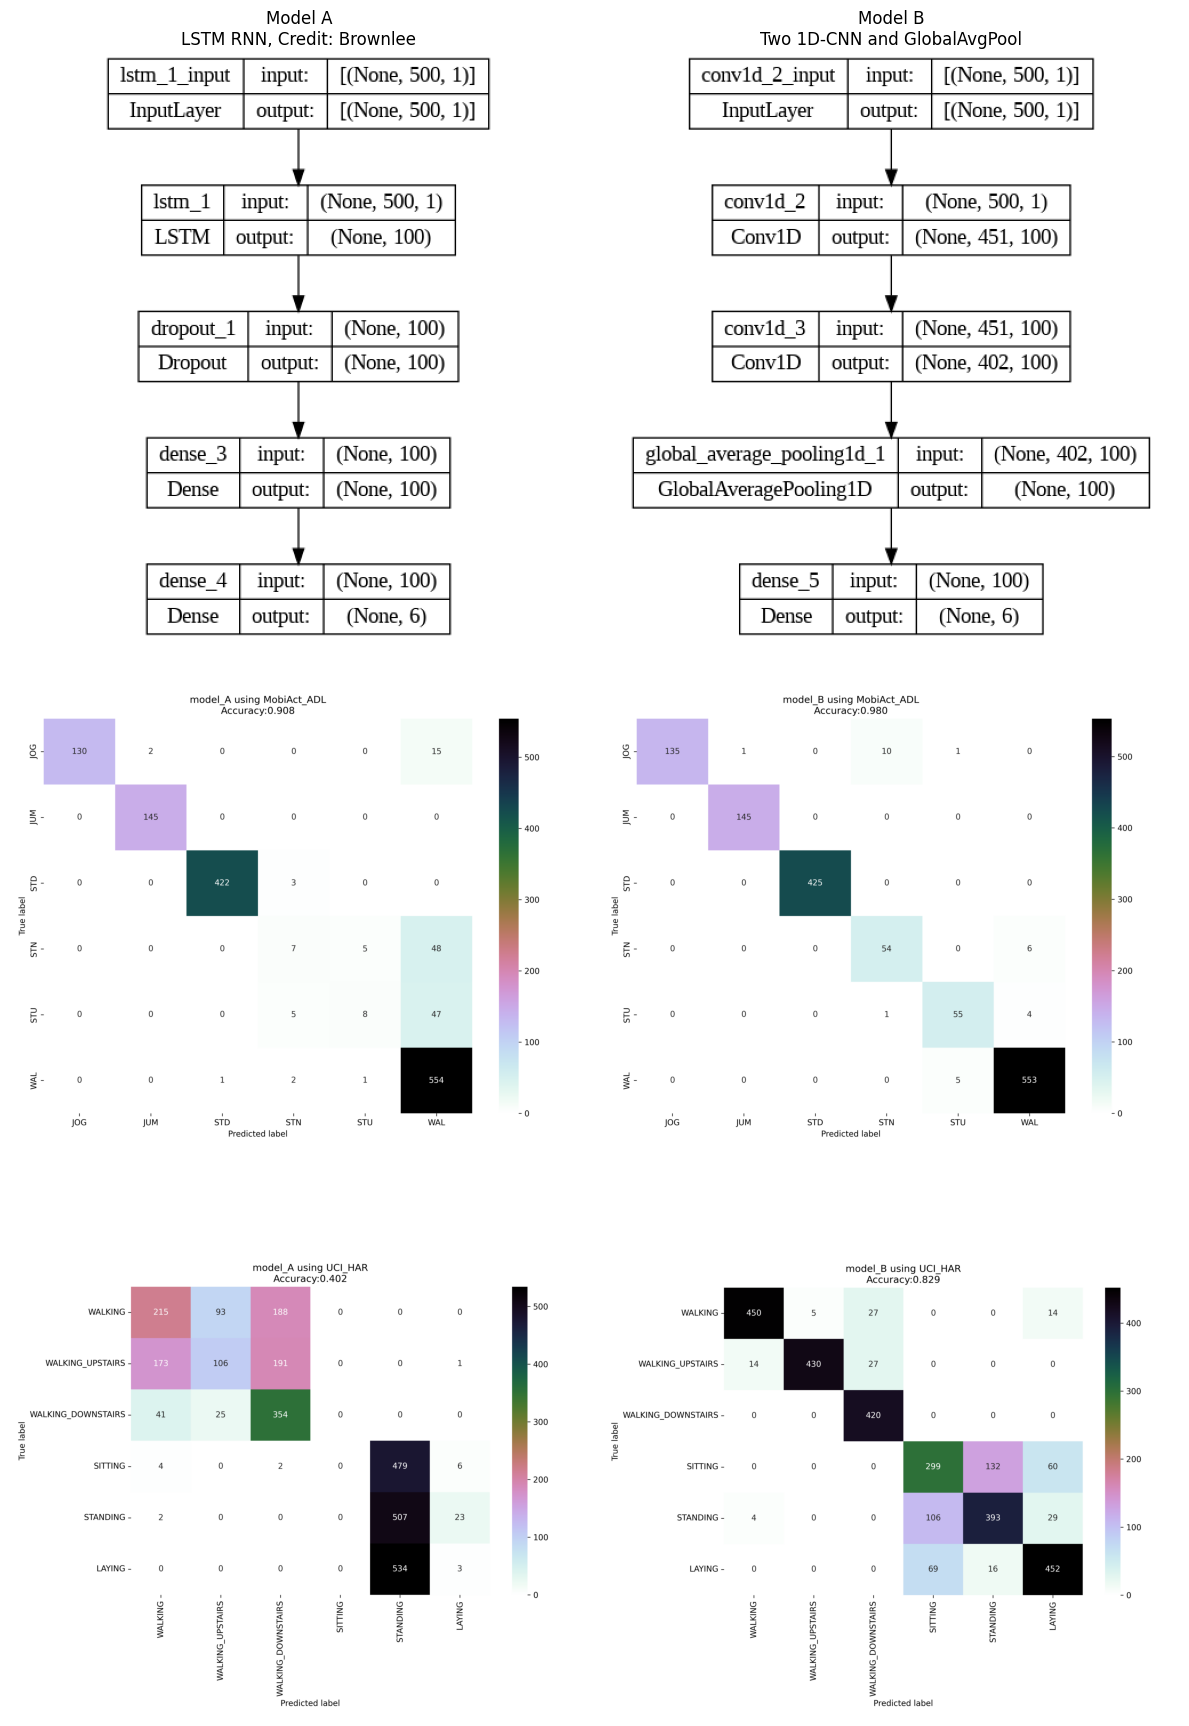

In [ ]:
#plot side by side only 2 confusion matrics
#https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html?highlight=subplots
#spacing needs to be adjusted
# see https://matplotlib.org/stable/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py
# see https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
rows = 3
cols = 2
fig, axs = plt.subplots(nrows=rows, ncols=cols)#, figsize = (40,10))
fig.set_size_inches(12,18)
for i in range(rows):
    for j in range(cols):
        axs[i, j].set_axis_off()
#axs[0, 0].set_title(modelA_results+'\n'+modelA_desc)
#axs[0, 1].set_title(modelB_results+'\n'+modelB_desc)
axs[0, 0].set_title('Model A\n'+ modelA_desc)
axs[0, 1].set_title('Model B\n'+ modelB_desc)
axs[0, 0].imshow(plt.imread('model_A_MobiAct_ADL.png'))
axs[0, 1].imshow(plt.imread('model_B_MobiAct_ADL.png'))
axs[1, 0].imshow(plt.imread('model_A_MobiAct_ADL_cm.png'))
axs[1, 1].imshow(plt.imread('model_B_MobiAct_ADL_cm.png'))
axs[2, 0].imshow(plt.imread('model_A_UCI_HAR_cm.png'))
axs[2, 1].imshow(plt.imread('model_B_UCI_HAR_cm.png'))

plt.tight_layout()
plt.savefig('throwdown2.png', dpi = 300) # don't forget to download!


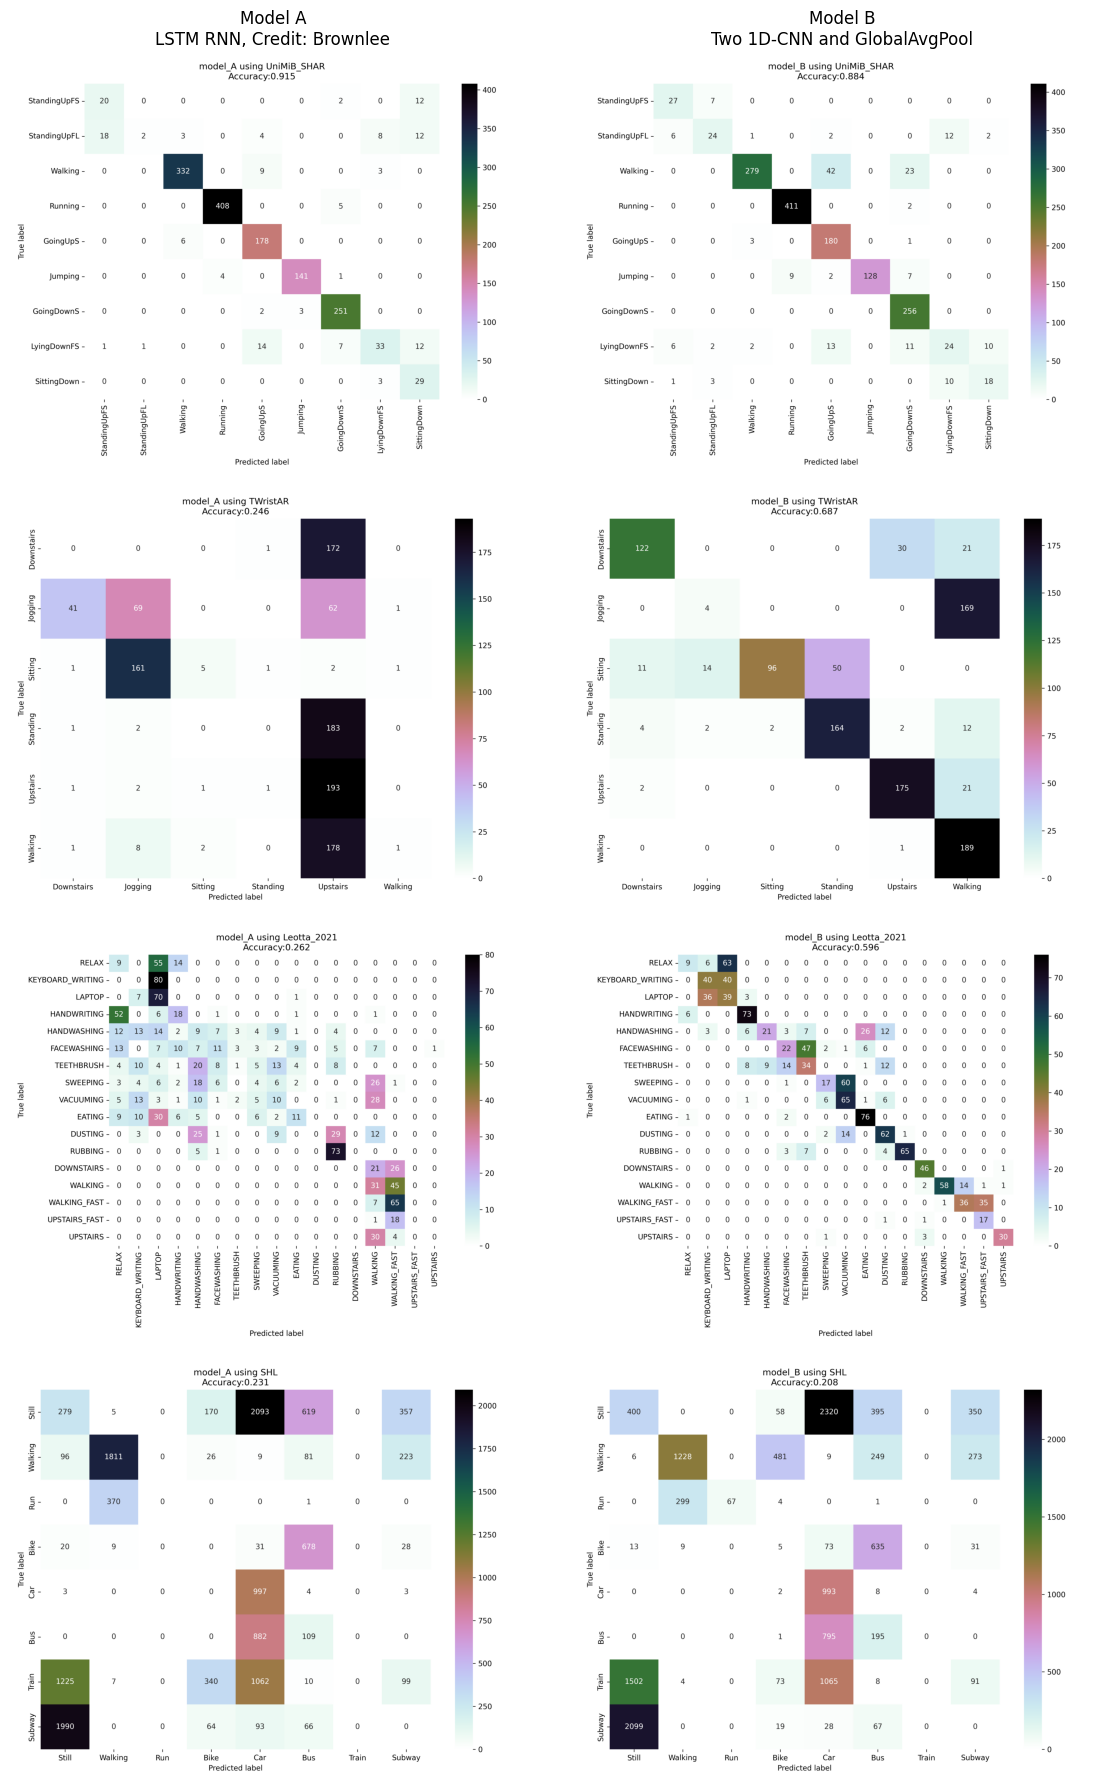

In [ ]:
#plot side by side next four confusion matrics
#https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html?highlight=subplots
#spacing needs to be adjusted
# see https://matplotlib.org/stable/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py
# see https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
rows = 4
cols = 2
fig, axs = plt.subplots(nrows=rows, ncols=cols)#, figsize = (40,10))
fig.set_size_inches(12,18)
for i in range(rows):
    for j in range(cols):
        axs[i, j].set_axis_off()
#axs[0, 0].set_title(modelA_results+'\n'+modelA_desc)
#axs[0, 1].set_title(modelB_results+'\n'+modelB_desc)
axs[0, 0].set_title('Model A\n'+ modelA_desc)
axs[0, 1].set_title('Model B\n'+ modelB_desc)
axs[0, 0].imshow(plt.imread('model_A_UniMiB_SHAR_cm.png'))
axs[0, 1].imshow(plt.imread('model_B_UniMiB_SHAR_cm.png'))
axs[1, 0].imshow(plt.imread('model_A_TWristAR_cm.png'))
axs[1, 1].imshow(plt.imread('model_B_TWristAR_cm.png'))
axs[2, 0].imshow(plt.imread('model_A_Leotta_2021_cm.png'))
axs[2, 1].imshow(plt.imread('model_B_Leotta_2021_cm.png'))
axs[3, 0].imshow(plt.imread('model_A_SHL_cm.png'))
axs[3, 1].imshow(plt.imread('model_B_SHL_cm.png'))

plt.tight_layout()
plt.savefig('throwdown3.png', dpi = 300) # don't forget to download!
